In [1]:
%pip install pandas
import pandas as pd
import os
import json
from pathlib import Path
%pip install seaborn
import seaborn as sns
%pip install matplotlib
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### DIFFICULTY SCORE CALCULUS

Methods used to calculate the Difficulty Score based on the gathered data

In [2]:
def normalize(x,min,max): # x min=1.58 max=9,5
    norm = (x - min)/(max-min)  #x - min(x) / max(x) - min(x)
    return float(norm)

In [3]:
def compute_score_dataset(df):
    df['Score_Norm'] = float(0.0)
    for index, row in df.iterrows():
        jointlist = ['LShoulderPitch','LShoulderRoll','LElbowYaw','LElbowRoll','LWristYaw','LHand','RShoulderPitch','RShoulderRoll','RElbowYaw','RElbowRoll','RWristYaw','RHand']
        num_joints = 0
        for j in jointlist:
            num_joints = num_joints + row['Answer'].count(j)
        num_joints = num_joints + row['Answer'].count('move')
        num_joints = num_joints + row['Answer'].count('say')
        num_tries = row['Num_tries']
        time_sec = row['Elapsed Time']
        score = 0.5*num_tries + 0.30*num_joints + 0.20*time_sec
        df.at[index,'Score'] = score
    scoreslist = list(df['Score'])
    max_value = max(scoreslist)
    min_value = min(scoreslist)
    for index, row in df.iterrows():
        selected_score = row['Score']
        if row['Corrected'] == 'Impossible':
            df.at[index,'Score'] = max_value #se il robot non riesce a completare il task, si assegna massima difficoltà al task
            selected_score = max_value
        df.at[index,'Score_Norm'] = normalize(selected_score,min_value,max_value)
    df.to_csv('./PromptTable_eval_with_Score.csv',index=False,sep=';')


### ACCURACY CALCULUS

In [4]:
df = pd.read_csv('./PromptTable_eval_with_Score.csv', sep=';')
df.head(6)

,Question,Answer,Failure,Elapsed Time,Num_tries,Corrected,GPT-version,Score_Norm,Score
0,"""Dammi il 5!""",nao.setAngle(['RShoulderPitch' 'RElbowRoll' ...,No,3.927,2.0,Yes,gpt-3.5-turbo,0.175142,3.2854
1,"""batti le mani""",nao.openHand('LHand')\r\nnao.openHand('RHand')...,No,16.022,7.0,Yes,gpt-3.5-turbo,0.944265,11.5044
2,"""Raccontami brevemente come si svolge la visit...","""Una visita cardiologica e un controllo medico...",Yes,12.151,2.0,Yes,gpt-3.5-turbo,0.188692,3.4302
3,"""batti il pugno""",nao.setAngle(['LShoulderPitch' 'LElbowRoll' ...,No,3.955,3.0,Yes,gpt-3.5-turbo,0.222455,3.7910
4,"""cammina""",nao.moveforward(0.5),No,3.158,2.0,Yes,gpt-3.5-turbo,0.048455,1.9316
5,"""Raccontami una breve favola.""","nao.say(\""C'era una volta in un bosco incantat...",No,5.785,1.0,No,gpt-3.5-turbo,0.050832,1.9570


Accuracy calculus with no error correction involved

In [5]:
def accuracy_vanilla_score_gpt3_gpt4(df):
    num_correct = 0
    num_total = df.shape[0]
    for index, row in df.iterrows():
        if row['Corrected'] == 'No':
            num_correct = num_correct + 1

    return num_correct / num_total


print(accuracy_vanilla_score_gpt3_gpt4(df))

0.5824175824175825


Accuracy calculus with the error correction involved

In [6]:
def accuracy_correction_score_gpt3_gpt4(df):
    num_with_correction = 0
    num_total = df.shape[0]
    for index, row in df.iterrows():
        if row['Corrected'] != 'Impossible':
            num_with_correction = num_with_correction + 1

    return num_with_correction / num_total


print(accuracy_correction_score_gpt3_gpt4(df))

0.9230769230769231


ACCURACY CALCULUS WITH DIFFICULTY LEVEL

With the Error Correction involved

In [7]:
def accuracy_correction_score_gpt3_easy(df):
    num_with_correction = 0
    df = df[df['Score'] < 2.0]  #### 0.0 <= score < 2.0 Easy
    df = df[df['Score'] >= 0.0]
    num_total = df.shape[0]
    for index, row in df.iterrows():
        if row['Corrected'] != 'Impossible':
            num_with_correction = num_with_correction + 1

    return num_with_correction / num_total


print(accuracy_correction_score_gpt3_easy(df))

1.0


In [8]:
def accuracy_correction_score_gpt3_medium(df):
    num_with_correction = 0
    df = df[df['Score'] < 4.0]   #2.0 <= score < 4.0 Medium
    df = df[df['Score'] >= 2.0]
    num_total = df.shape[0]
    for index, row in df.iterrows():
        if row['Corrected'] != 'Impossible':
            num_with_correction = num_with_correction + 1

    return num_with_correction / num_total


print(accuracy_correction_score_gpt3_medium(df))

1.0


In [9]:
def accuracy_correction_score_gpt3_hard(df):
    num_with_correction = 0
    df = df[df['Score'] >= 4.0] #score >= 4  Hard
    num_total = df.shape[0]
    for index, row in df.iterrows():
        if row['Corrected'] != 'Impossible':
            num_with_correction = num_with_correction + 1

    return num_with_correction / num_total


print(accuracy_correction_score_gpt3_hard(df))

0.72


With no error correction involved

In [10]:
def accuracy_vanilla_score_gpt3_easy(df):
    num_with_correction = 0
    df = df[df['Score'] < 2.0]  #### 0.0<= score < 2.0 Easy
    df = df[df['Score'] >= 0.0]
    num_total = df.shape[0] 
    for index, row in df.iterrows():
        if row['Corrected'] == 'No':
            num_with_correction = num_with_correction + 1

    return num_with_correction / num_total


print(accuracy_vanilla_score_gpt3_easy(df))

0.96


In [11]:
def accuracy_vanilla_score_gpt3_medium(df):
    num_with_correction = 0
    df = df[df['Score'] < 4.0]  #### 2.0 <= score < 4.0 Medium
    df = df[df['Score'] >= 2.0]
    num_total = df.shape[0] 
    for index, row in df.iterrows():
        if row['Corrected'] == 'No':
            num_with_correction = num_with_correction + 1

    return num_with_correction / num_total


print(accuracy_vanilla_score_gpt3_medium(df))

0.6097560975609756


In [14]:
def accuracy_vanilla_score_gpt3_hard(df):
    num_with_correction = 0  
    df = df[df['Score'] >= 4.0]#### score >= 4.0 Hard
    num_total = df.shape[0] + 1
    for index, row in df.iterrows():
        if row['Corrected'] == 'No':
            num_with_correction = num_with_correction + 1

    return num_with_correction / num_total


print(accuracy_vanilla_score_gpt3_hard(df))

0.15384615384615385


Cumulative Accuracy Table per Difficulties

In [15]:
df_evaluation_results = pd.DataFrame([[round(accuracy_vanilla_score_gpt3_easy(df),2), round(accuracy_vanilla_score_gpt3_medium(df),2), round(accuracy_vanilla_score_gpt3_hard(df),2)], [round(accuracy_correction_score_gpt3_easy(df),2),round(accuracy_correction_score_gpt3_medium(df),2),round(accuracy_correction_score_gpt3_hard(df),2)]], index=['Vanilla','Correction'], columns = ['Easy','Medium','Hard'])
df_evaluation_results

,Easy,Medium,Hard
Vanilla,0.96,0.61,0.15
Correction,1.00,1.00,0.72


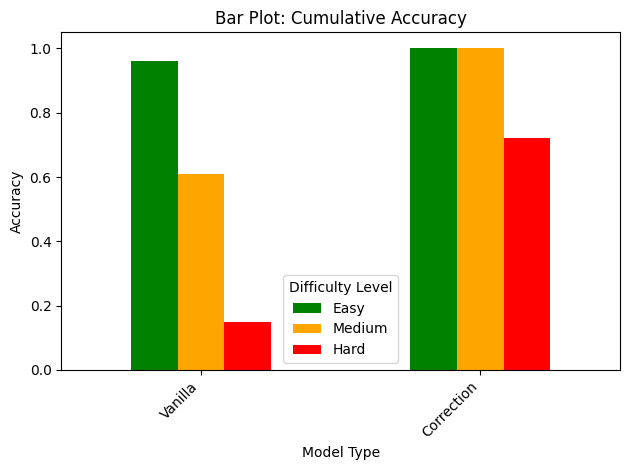

In [16]:
c = ['green', 'orange', 'red']
df_evaluation_results.plot(kind='bar', color= c, stacked=False)

plt.title('Bar Plot: Cumulative Accuracy')
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Difficulty Level')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()